In [ ]:
#|default_exp data.image

# Imaging Time Series

>Main functions used to transform time series into TSImage tensors.

In [ ]:
#|export
from tsai.imports import *
from matplotlib.backends.backend_agg import FigureCanvasAgg
from pyts.image.gaf import GramianAngularField
from pyts.image import MarkovTransitionField, RecurrencePlot
from pyts.multivariate.image import JointRecurrencePlot
from fastai.vision.augment import *
from fastai.vision.core import *
from tsai.utils import *
from tsai.data.external import *
from tsai.data.core import *
from tsai.data.preprocessing import *
from tsai.data.transforms import *

In [ ]:
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, return_split=False)

In [ ]:
#|export
class TSImage(TensorImage):
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return res.as_subclass(type(self))

    @property
    def vars(self):
        return self.shape[-3]

    @property
    def len(self): return self.shape[-2:]

    def __repr__(self):
        if self.ndim == 0: return f'{self.data}'
        else: return f'TSImage(shape:{self.shape})'

    def show(self, **kwargs):
        if self.ndim < 3:
            while True:
                self = self[None]
                if self.ndim == 3: break
        elif self.ndim > 3:
            while True:
                self = self[0]
                if self.ndim == 3: break
        if self[:3].shape[0] == 3 and kwargs == {}:
            display(to_image(self[:3]))
            return
        else:
            TensorImage(self[:3]).show(**kwargs)
            return


class ToTSImage(Transform):
    order = 99
    "Transforms an object into TSImage"
    def encodes(self, o: TensorImage): return TSImage(o)

In [ ]:
#|export
class TSToPlot(Transform):
    r"""Transforms a time series batch to a 4d TSImage (bs, n_vars, size, size) by creating a matplotlib plot."""
    order = 98

    def __init__(self, size:Optional[int]=224, dpi:int=default_dpi(), lw=1, **kwargs):
        self.size, self.dpi, self.lw, self.kwargs = size, dpi, lw, kwargs
        self.fig = get_plot_fig(size, dpi=dpi)

    def encodes(self, o: TSTensor):
        device = o.device
        if o.data.device.type != 'cpu': o = o.cpu()
        if o.ndim == 2: o = o[None]
        seq_len = o.shape[-1]
        fig = self.fig
        if self.size is None: fig.set_size_inches(seq_len / self.dpi, seq_len / self.dpi)
        canvas = FigureCanvasAgg(fig)
        ax = fig.get_axes()[0]
        ax.set_xlim(0, seq_len - 1)
        output = []
        for oi in o:
            start = time.time()
            ax.plot(oi.T.numpy(), lw=self.lw, **self.kwargs)
            canvas.draw()
            buf = np.asarray(canvas.buffer_rgba())[..., :3]
            output.append(tensor(buf / 255).permute(2,0,1)[None])
        return TSImage(torch.cat(output)).to(device=device)

torch.Size([2, 3, 224, 224])


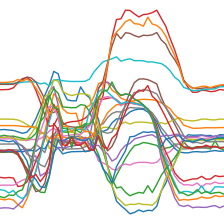

In [ ]:
out = TSToPlot()(TSTensor(X[:2]), split_idx=0)
print(out.shape)
out[0].show()

In [ ]:
#|export
class TSToMat(Transform):
    r"""Transforms a time series batch to a 4d TSImage (bs, n_vars, size, size) by creating a matplotlib matrix.
    Input data must be normalized with a range(-1, 1)"""
    order = 98

    def __init__(self, size=224, dpi=default_dpi(), cmap=None, **kwargs):
        self.size, self.dpi, self.cmap, self.kwargs = size, dpi, cmap, kwargs

    def encodes(self, o: TSTensor):
        device = o.device
        if o.data.device.type != 'cpu': o = o.cpu()
        if o.ndim == 2: o = o[None]
        nvars, seq_len = o.shape[-2:]
        aspect = seq_len / nvars
        size = ifnone(self.size, seq_len)
        fig = get_plot_fig(self.size, dpi=self.dpi)
        ax = fig.get_axes()[0]
        ax.set_xlim(0, seq_len-1)
        canvas = FigureCanvasAgg(fig)
        output = []
        for oi in o:
            if output == []: im = ax.imshow(oi, aspect=aspect, vmin=-1, vmax=1, cmap=self.cmap, **self.kwargs)
            else: im.set_data(oi)
            canvas.draw()
            buf = np.asarray(canvas.buffer_rgba())[..., :3]
            canvas.flush_events()
            output.append(tensor(buf / 255).permute(2,0,1)[None])
        return TSImage(torch.cat(output)).to(device=device)

torch.Size([2, 3, 224, 224])


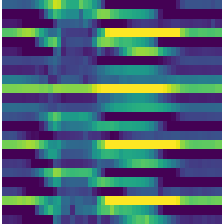

In [ ]:
out = TSToMat()(TSTensor(X[:2]), split_idx=0)
print(out.shape)
out[0].show()

torch.Size([2, 3, 224, 224])


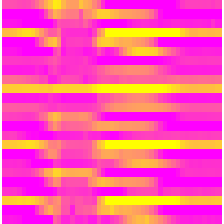

In [ ]:
out = TSToMat(cmap='spring')(TSTensor(X[:2]), split_idx=0)
print(out.shape)
out[0].show()

In [ ]:
#|export
@delegates(GramianAngularField.__init__)
class TSToGADF(Transform):
    r"""Transforms a time series batch to a 4d TSImage (bs, n_vars, size, size) by applying Gramian Angular Difference Field.
    It requires either input to be previously normalized between -1 and 1 or set range to (-1, 1)"""
    order = 98

    def __init__(self, size=224, cmap=None, range=None, **kwargs):
        self.size,self.cmap,self.range = size,cmap,range
        self.encoder = GramianAngularField(image_size=1., sample_range=self.range, method='d', **kwargs)

    def encodes(self, o: TSTensor):
        bs, *_, seq_len = o.shape
        size = ifnone(self.size, seq_len)
        if size != seq_len:
            o = F.interpolate(o.reshape(-1, 1, seq_len), size=size, mode='nearest', align_corners=None)[:, 0]
        else:
            o = o.reshape(-1, seq_len)
        output = self.encoder.fit_transform(o.cpu().numpy()).reshape(bs, -1, size, size) / 2 + .5
        if self.cmap and output.shape[1] == 1:
            output = TSImage(plt.get_cmap(self.cmap)(output)[..., :3]).squeeze(1).permute(0,3,1,2)
        else: output = TSImage(output)
        return output.to(device=o.device)


@delegates(GramianAngularField.__init__)
class TSToGASF(Transform):
    r"""Transforms a time series batch to a 4d TSImage (bs, n_vars, size, size) by applying Gramian Angular Summation Field.
    It requires either input to be previously normalized between -1 and 1 or set range to (-1, 1)"""
    order = 98

    def __init__(self, size=224, cmap=None, range=None, **kwargs):
        self.size,self.cmap,self.range = size,cmap,range
        self.encoder = GramianAngularField(image_size=1., sample_range=self.range, method='s', **kwargs)

    def encodes(self, o: TSTensor):
        bs, *_, seq_len = o.shape
        size = ifnone(self.size, seq_len)
        if size != seq_len:
            o = F.interpolate(o.reshape(-1, 1, seq_len), size=size, mode='nearest', align_corners=None)[:, 0]
        else:
            o = o.reshape(-1, seq_len)
        output = self.encoder.fit_transform(o.cpu().numpy()).reshape(bs, -1, size, size) / 2 + .5
        if self.cmap and output.shape[1] == 1:
            output = TSImage(plt.get_cmap(self.cmap)(output)[..., :3]).squeeze(1).permute(0,3,1,2)
        else: output = TSImage(output)
        return output.to(device=o.device)



@delegates(MarkovTransitionField.__init__)
class TSToMTF(Transform):
    r"""Transforms a time series batch to a 4d TSImage (bs, n_vars, size, size) by applying Markov Transition Field"""
    order = 98

    def __init__(self, size=224, cmap=None, n_bins=5, **kwargs):
        self.size,self.cmap = size,cmap
        self.encoder = MarkovTransitionField(n_bins=n_bins, **kwargs)

    def encodes(self, o: TSTensor):
        bs, *_, seq_len = o.shape
        size = ifnone(self.size, seq_len)
        if size != seq_len:
            o = F.interpolate(o.reshape(-1, 1, seq_len), size=size, mode='nearest', align_corners=None)[:, 0]
        else:
            o = o.reshape(-1, seq_len)
        output = self.encoder.fit_transform(o.cpu().numpy()).reshape(bs, -1, size, size)
        if self.cmap and output.shape[1] == 1:
            output = TSImage(plt.get_cmap(self.cmap)(output)[..., :3]).squeeze(1).permute(0,3,1,2)
        else: output = TSImage(output)
        return output.to(device=o.device)


@delegates(RecurrencePlot.__init__)
class TSToRP(Transform):
    r"""Transforms a time series batch to a 4d TSImage (bs, n_vars, size, size) by applying Recurrence Plot.
    It requires input to be previously normalized between -1 and 1"""
    order = 98

    def __init__(self, size=224, cmap=None, **kwargs):
        self.size,self.cmap = size,cmap
        self.encoder = RecurrencePlot(**kwargs)

    def encodes(self, o: TSTensor):
        bs, *_, seq_len = o.shape
        size = ifnone(self.size, seq_len)
        if size != seq_len:
            o = F.interpolate(o.reshape(-1, 1, seq_len), size=size, mode='nearest', align_corners=None)[:, 0]
        else:
            o = o.reshape(-1, seq_len)
        output = self.encoder.fit_transform(o.cpu().numpy()) / 2
        output = output.reshape(bs, -1, size, size)
        if self.cmap and output.shape[1] == 1:
            output = TSImage(plt.get_cmap(self.cmap)(output)[..., :3]).squeeze(1).permute(0,3,1,2)
        else: output = TSImage(output)
        return output.to(device=o.device)


@delegates(JointRecurrencePlot.__init__)
class TSToJRP(Transform):
    r"""Transforms a time series batch to a 4d TSImage (bs, n_vars, size, size) by applying Joint Recurrence Plot"""
    order = 98

    def __init__(self, size=224, cmap=None, **kwargs):
        self.size,self.cmap = size,cmap
        self.encoder = JointRecurrencePlot(**kwargs)

    def encodes(self, o: TSTensor):
        o = to3d(o)
        bs, *_, seq_len = o.shape
        size = ifnone(self.size, seq_len)
        if size != seq_len: o = F.interpolate(o, size=size, mode='nearest', align_corners=None)
        output = self.encoder.fit_transform(o.cpu().numpy()).reshape(bs, -1, size, size)
        if self.cmap and output.shape[1] == 1:
            output = TSImage(plt.get_cmap(self.cmap)(output)[..., :3]).squeeze(1).permute(0,3,1,2)
        else: output = TSImage(output)
        return output.to(device=o.device)

torch.Size([2, 24, 224, 224])


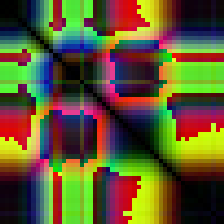

In [ ]:
out = TSToRP()(TSTensor(X[:2]), split_idx=0)
print(out.shape)
out[0].show()

In [ ]:
o = TSTensor(X[0][1][None])
encoder = RecurrencePlot()
a = encoder.fit_transform(o.cpu().numpy())[0]
o = TSTensor(X[0])
encoder = RecurrencePlot()
b = encoder.fit_transform(o.cpu().numpy())[1]
test_eq(a,b) # channels can all be processed in parallel

In [ ]:
test_eq(TSToRP()(TSTensor(X[0]), split_idx=False)[0], TSToRP()(TSTensor(X[0][0][None]), split_idx=False)[0])
test_eq(TSToRP()(TSTensor(X[0]), split_idx=False)[1], TSToRP()(TSTensor(X[0][1][None]), split_idx=False)[0])
test_eq(TSToRP()(TSTensor(X[0]), split_idx=False)[2], TSToRP()(TSTensor(X[0][2][None]), split_idx=False)[0])

0 Plot TSImage(shape:torch.Size([8, 3, 100, 100])) torch.float32 0.054901961237192154 1.0


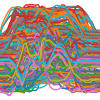

1 Mat TSImage(shape:torch.Size([8, 3, 100, 100])) torch.float32 0.019607843831181526 1.0


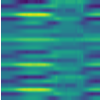

2 GADF TSImage(shape:torch.Size([8, 24, 100, 100])) torch.float32 2.980232238769531e-07 0.9999997019767761


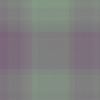

3 GASF TSImage(shape:torch.Size([8, 24, 100, 100])) torch.float32 0.0 0.938302218914032


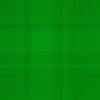

4 MTF TSImage(shape:torch.Size([8, 24, 100, 100])) torch.float32 0.0 1.0


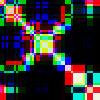

5 RP TSImage(shape:torch.Size([8, 24, 100, 100])) torch.float32 0.0 0.8106333613395691


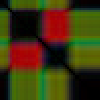

In [ ]:
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, return_split=False)
tfms = [None, Categorize()]
bts = [[TSNormalize(), TSToPlot(100)],
       [TSNormalize(), TSToMat(100)],
       [TSNormalize(), TSToGADF(100)],
       [TSNormalize(), TSToGASF(100)],
       [TSNormalize(), TSToMTF(100)],
       [TSNormalize(), TSToRP(100)]]
btns = ['Plot', 'Mat', 'GADF', 'GASF', 'MTF', 'RP']
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
for i, (bt, btn) in enumerate(zip(bts, btns)):
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=8, batch_tfms=bt)
    test_eq(dls.vars, 3 if i <2 else X.shape[1])
    test_eq(dls.vars, 3 if i <2 else X.shape[1])
    test_eq(dls.len, (100,100))
    xb, yb = dls.train.one_batch()
    print(i, btn, xb, xb.dtype, xb.min(), xb.max())
    xb[0].show()
    plt.show()

The simplest way to train a model using time series to image transforms is this: 
```
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, return_split=False)
tfms = [None, Categorize()]
batch_tfms = [TSNormalize(), TSToGADF(224)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
learn = tsimage_learner(dls, xresnet34)
learn.fit_one_cycle(10)
```

In [ ]:
#|eval: false
#|hide
from tsai.export import get_nb_name; nb_name = get_nb_name(locals())
from tsai.imports import create_scripts; create_scripts(nb_name)

<IPython.core.display.Javascript object>

/Users/nacho/notebooks/tsai/nbs/012_data.image.ipynb saved at 2024-02-10 22:40:32
Correct notebook to script conversion! 😃
Saturday 10/02/24 22:40:35 CET
